In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
# Load data
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from tqdm import tqdm
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    #table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower() for text in texts]
    #.translate(table)
    return texts

In [6]:
adm_notes = adm_notes.dropna(subset=['TEXT'])

adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

# Model
## Words, Train and Test

Repartition data

In [7]:
df_train, df_test = train_test_split(adm_notes, test_size=0.3)

Subsample non-readmitted patients to match size of readmitted ones

In [8]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [9]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [10]:
df_test, df_val = train_test_split(df_test, test_size=0.5)

df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)
df_val = df_val.sample(n = len(df_val)).reset_index(drop = True)

# Recurrent Neural Network

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import tensorflow_hub as hub

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, glue_convert_examples_to_features
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer


In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels = 2, 
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
pad_token = 0
pad_token_segment_id = 0
max_length = 512

def convert_to_input(texts):
    input_ids, attention_masks, token_type_ids = [], [], []
    for text in tqdm(texts, position=0, leave=True):
        if pd.isna(text):
            continue
        inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, return_token_type_ids=True, truncation=True)
        
        i, t = inputs["input_ids"], inputs["token_type_ids"]
        m = [1] * len(i)
        
        padding_length = max_length - len(i)
        
        i = i + ([pad_token] * padding_length)
        m = m + ([0] * padding_length)
        t = t + ([pad_token_segment_id] * padding_length)
        
        input_ids.append(i)
        attention_masks.append(m)
        token_type_ids.append(t)
    
    return [np.asarray(input_ids), np.asarray(attention_masks), np.asarray(token_type_ids)]

X_train_input = convert_to_input(df_train['TEXT'])
X_test_input = convert_to_input(df_test['TEXT'])
X_val_input = convert_to_input(df_val['TEXT'])

100%|██████████| 843/843 [00:35<00:00, 23.98it/s]


In [14]:
def to_features(input_ids, attention_masks, y):
    return {"input_ids": input_ids, "attention_mask": attention_masks}, y

# Assuming X_train_input, X_test_input, X_val_input contain input_ids and attention_mask without token_type_ids
train_data = (X_train_input[0], X_train_input[1], df_train['READM_WITHIN_30'])
test_data = (X_test_input[0], X_test_input[1], df_test['READM_WITHIN_30'])
val_data = (X_val_input[0], X_val_input[1], df_val['READM_WITHIN_30'])

train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(to_features).shuffle(len(df_train['READM_WITHIN_30'])).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(to_features).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).map(to_features).batch(16)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
258/258 [==============================] - 5937s 23s/step - loss: 0.6934 - accuracy: 0.5094 - val_loss: 0.6872 - val_accuracy: 0.5480
Epoch 2/3
258/258 [==============================] - 5904s 23s/step - loss: 0.6853 - accuracy: 0.5453 - val_loss: 0.6885 - val_accuracy: 0.5374
Epoch 3/3
258/258 [==============================] - 5935s 23s/step - loss: 0.6699 - accuracy: 0.5964 - val_loss: 0.6725 - val_accuracy: 0.5955


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(test_ds, verbose=1)
y_pred_class = np.argmax(y_pred[0], axis=1)

print(classification_report(df_test['READM_WITHIN_30'], y_pred_class, digits=3))
print(roc_auc_score(df_test['READM_WITHIN_30'], y_pred_class))

53/53 [==============================] - 349s 7s/step
              precision    recall  f1-score   support

           0      0.528     0.848     0.651       415
           1      0.642     0.264     0.374       428

    accuracy                          0.552       843
   macro avg      0.585     0.556     0.512       843
weighted avg      0.586     0.552     0.510       843

0.5561057313365612


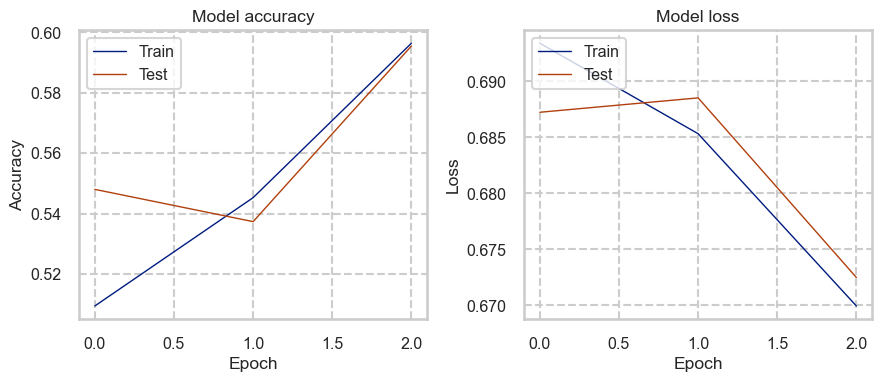

In [17]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

In [18]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


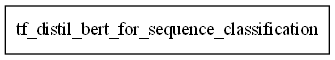

In [19]:
from keras.utils import plot_model
plot_model(model)